<a href="https://colab.research.google.com/github/gardiens/MVA_24_25/blob/main/MVA_SAT/project/clean_up_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triangulation and Digital Elevation Models

The objective of this practical session is to study the creation and processing of 3D
models computed from satellite images.  The extraction of 3D points from
image correspondences is called *triangulation*.  The processing of generic
3D point clouds is a very general problem, out of the scope of the present
course. Here, we will content ourselves with the much simpler 2.5D models
that, in the context of geographic imaging, are called *digital elevation
models* (D.E.M.).

We cover the following topics:
* How to find the vertical direction of an image
* How to obtain a 3D point from a match between two images
* How the precision of the point varies according to the baseline
* Computation of a dense point cloud
* Computation of a D.E.M. from a point cloud
* Visualization, ~~filtering, interpolation, registration~~ and fusion of D.E.M.


#### Instructions
To solve this practical session, answer the questions below. Then, clear all the output cells using the menu option **Cell->All Output->Clear** and export the notebook with your answers using the menu option **File -> Download as -> Notebook (.ipynb)**. Then [submit the resulting file here](https://forms.gle/k6FSX2BrPix823dx6) by next week. You will receive an automatic acknowledgement of receipt.

There are 4 compulsory exercises, plus 3 optional ones:
* Exercise 1. Find the vertical direction of an image _(warm-up exercise)_
* Exercise 2. Affine triangulation of a match _(head-scratching, requires quite a bit of hand computation)_
* Exercise 3. Qualitative evaluation of high vs. low-baseline results _(only conceptual)_
* Exercise 4. (given) Obtain a dense point cloud by triangulating a disparity map _(plug existing functions)_
* Exercise 5. (given) Projection of a 3D point cloud into a DEM _(easy to do, hard to get 100% right)_
* Exercise 6. Merge several DEM into a single one _(easy)_
* Exercise 7. (optional) Create a 3D point cloud from a DEM _(easy for pythonists)_
* Exercise 8. (optional) Create a complete 3D point cloud _(difficult)_

**Note:** A correct solution of exercise 2 is _essential_ because all the following exercises depend on it.

<!--
## Overview of notations

$(x,y)$, $(i,j)$ pixel coordinates in the domain of an image

$(\lambda,\theta,h)$ latitude, longitude, height of a 3D point

$(e,n,h)$ easting, northing, height of a 3D point (the UTM zone is implicit)

$A, B, \ldots$ gray-level images

$A(x,y)$ pixel value at coordinates $(x,y)$ of image $A$

$P_A(\lambda,\theta,h), L_A(x,y,h)$ projection and localization functions
of image $A$

$u, v, \ldots$ raster images representing digital elevation models in
meters

$u(i,j)$ value of $u$ at the pixel $(i,j)$

$u(e,n)$ height of the point at geographic coordinates $(e,n)$

$u(\lambda,\theta)$ height of the point at geographic coordinates
$(\lambda,\theta)$
-->

In [3]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run'
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output.

# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files

    # download TP data and tools
    !wget -q http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/tp4.zip
    !unzip -q -o tp4.zip

    # install dependencies
    !python -m pip -q install rpcm
    !pip install -q 'ad @ git+https://github.com/DapengFeng/ad'
    !python -m pip -q install numpy matplotlib scipy geojson pyproj opencv-contrib-python==4.8.0.76 rasterio srtm4 folium numba pypotree

except ImportError:
    %matplotlib notebook
    pass


## Setup code for the notebook
##
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


# general imports
import numpy as np                   # numeric linear algebra
from scipy import ndimage            # only for ndimage.affine_transform
import matplotlib.pyplot as plt      # plotting
import rpcm                          # RPC model

# imports specific to this course
import utils          # IO and conversion tools (from TP-collection)
import vistools       # display tools (from TP-collection)
import rectification  # rectification tools (from TP-rectification)
import stereo         # stereo matching tools (from TP-stereo)
import folium

# display hacks
np.set_printoptions(linewidth=80)

  Preparing metadata (setup.py) ... done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Tokyo dataset

For this session we use the Tokyo series of 23 Pléiades images, acquired
during a single orbit.  Notice that the satellite has to rotate very fast
and very accurately to point the camera towards the city as it flies all over
it in a few seconds.

In [4]:
# list the tiff images available in the remote folder
myimages = utils.find('http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/', 'TIF')
print(f"Found {len(myimages)} images")
myimages[0:4]

Found 23 images


['http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0137454_PHR1B_P/IMG_PHR1B_P_201301030137454_SEN_IPU_20141022_6527-003_R1C1.JP2.TIF',
 'http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0137571_PHR1B_P/IMG_PHR1B_P_201301030137571_SEN_IPU_20141022_6532-003_R1C1.JP2.TIF',
 'http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0138084_PHR1B_P/IMG_PHR1B_P_201301030138084_SEN_IPU_20141022_6544-003_R1C1.JP2.TIF',
 'http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0138195_PHR1B_P/IMG_PHR1B_P_201301030138195_SEN_IPU_20141022_6554-003_R1C1.JP2.TIF']

In [5]:
# keep only the panchromatic (P) images, discard the multispectral (MS)
myimages = [x for x in myimages if "_P_" in x]
myimages[0:4]

['http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0137454_PHR1B_P/IMG_PHR1B_P_201301030137454_SEN_IPU_20141022_6527-003_R1C1.JP2.TIF',
 'http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0137571_PHR1B_P/IMG_PHR1B_P_201301030137571_SEN_IPU_20141022_6532-003_R1C1.JP2.TIF',
 'http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0138084_PHR1B_P/IMG_PHR1B_P_201301030138084_SEN_IPU_20141022_6544-003_R1C1.JP2.TIF',
 'http://menthe.ovh.hw.ipol.im/IARPA_data/tokyo_20130103/0138195_PHR1B_P/IMG_PHR1B_P_201301030138195_SEN_IPU_20141022_6554-003_R1C1.JP2.TIF']

In the exercises below we propose to use a fixed area of interest around the Skytree tower.  Optionally, you can select a different scene of your choice, using the `foliummap` function from the `vistools` module.

# Finding the vertical direction

The first question is just for *warming up* using the RPC and image extraction
functions from the previous sessions.

**Exercise 1.** Implement the 'crop_vertical' function.  This function
should extract the requested *Area of interest* (AOI) from an image and rotate it so that the vertical direction in space points upwards in the rotated image domain.  You
can compute the vertical direction by evaluating the RPC functions on 2
points at different heights.  The structure of this function is already given, you only need to complete the 'find_vertical_direction' function.

Apply your function to an area around Skytree Tower (coordinates $35.710139, 139.810833$) or Tokyo Tower (coordinates $35.658611, 139.745556$) to verify that the building is indeed vertical.

In [6]:
# coordinates around Sky Tree's base (the second tallest building in the world)
aoi_skytree = {'type': "Polygon", 'coordinates': [[
    [139.808, 35.7119],
    [139.807, 35.7078],
    [139.815, 35.7078],
    [139.815, 35.7123],
    [139.808, 35.7119]
]]
}

In [7]:
# crop the region of interest on the first image
crop, offset_x, offset_y = utils.crop_aoi(myimages[0], aoi_skytree)
rpc = rpcm.rpc_from_geotiff(myimages[0])

In [8]:
# code for Exercise 1
def find_vertical_direction(rpc):
    """
    Return the vertical direction associated to an image.

    Arguments:
        rpc: RPC function of the image

    Return:
        p, q : the vertical direction in the image domain (a normalized 2D vector)
    """

    # EXERCISE 1 : WRITE THE CODE FOR THIS FUNCTION
    p,q=rpc.localization(0,0,10)
    p2,q2=rpc.localization(0,0,100)

    # project into the image space
    p,q=rpc.projection(p,q,100)
    p2,q2=rpc.projection(p2,q2,100)
    # return the projected
    return (p-p2)/np.linalg.norm([p-p2,q-q2]),(q-q2)/np.linalg.norm([p-p2,q-q2])



# build a rotation matrix that sets the 3D vertical direction upwards
def build_verticalizing_rotation(rpc, shape):
    p, q = find_vertical_direction(rpc)                   # cosine and sine
    p, q = -q, p                                          # ndimage convention for rows/cols
    x, y = shape[1]/2, shape[0]/2                         # center of rotation (middle of the image domain)
    T = np.array([[ 1,  0, -x], [0,  1, -y], [0, 0, 1]])  # translate (x,y) to the origin
    R = np.array([[ p, q,  0], [-q,  p,  0], [0, 0, 1]])  # rotate by the requested angle
    R = np.linalg.inv(T) @ R @ T                          # full rotation matrix
    return R

# like crop_aoi, but rotates the image after cropping
def crop_vertical(image, aoi, base_h=0):
    rpc = rpcm.rpc_from_geotiff(image)
    x, y, w, h = utils.bounding_box_of_projected_aoi(rpc, aoi, z=base_h)
    R = build_verticalizing_rotation(rpc, (h, w))
    R = np.dot(R, utils.matrix_translation(-x, -y))  # compensate for the crop offset
    return rectification.affine_crop(image, R, w, h)

In [9]:
# compare the crop of an image with and without the verticalizing rotation
base_h = 45
a, _, _ = utils.crop_aoi(myimages[0], aoi_skytree, base_h)
b    = crop_vertical(myimages[0], aoi_skytree, base_h)

qa = utils.simplest_color_balance_8bit(a)
qb = utils.simplest_color_balance_8bit(b)

The following code is used to test your implementation of vertical crop.  You should obtain a timeseries of images such that the vertical direction always points upwards.  **Note:** to evaluate your answer to Question 1 we will run the code below and check visually if the sequence of vertical crops is, indeed, vertical.

In [10]:
# auxiliary function with the same interface as crop_vertical
def crop_rectangular(image, aoi, base_h=0):
    a, _, _ = utils.crop_aoi(image, aoi, base_h)
    return a

In [11]:
# build a timeseries of crops (without rotation)
crops = [crop_rectangular(x, aoi_skytree, base_h) for x in myimages]

In [12]:
# build a timeseries of crops (rotated in the vertical direction)
vcrops = [crop_vertical(x, aoi_skytree, base_h) for x in myimages]

In [13]:
# quantize the crops to 8 bits
q_crops  = [utils.simplest_color_balance_8bit(x) for x in crops]
q_vcrops = [utils.simplest_color_balance_8bit(x) for x in vcrops]

# Triangulation of a point

Triangulation consists in finding the position of a 3D point from its projection into two images.  It is also called *intersection* because it can be interpreted as the intersection of two rays in space.  If $x$ is a point in the domain of image $A$ and $x'$ is a point in the domain of image $A'$, the intersection is found by solving the following equation for $h$ : $L_A(x,h)=L_{A'}(x',h)$.  Then, the 3D point of intersection is either $L_A(x,h)$ or $L_{A'}(x',h)$.  This is a system of two equations with a single unknown $h$, so in general it will not have a solution.  In that case, we can define the "solution" by the value of $h$ that minimizes, for example, the error $e(h)=\|L_A(x,h)-L_{A'}(x',h)\|^2$.  Then, we obtain the 3D point by evaluating the localization function $L_A$.  Thus, the solution is a 3D point that, when projected into image $A$, it falls exactly on $x$, but when projected on image $A'$ it may be a bit far from $x'$.  Note that there are other reasonable energies to minimize, leading to (slightly) different results.  For example $e(h)=\|P_{A'}(L_A(x,h),h)-x'\|^2$.

**Exercise 2** Implement the `triangulation_affine` function that finds the position of a 3D point given a correspondence between two images.  This function should be reasonably fast, because you will want to apply it to all the pixels of an image to obtain a dense 3D cloud.  We give you a slow, naive implementation based on iterative minimization of the error. You should write a fast implementation based on the affine approximation of the RPC functions developed in the session on rectification. Notice that in this case the triangulation function has a closed, linear form. Verify that your implementation gives the same results as triangulation_iterative (up to a few centimeters).

**Note:** Solving this exercise is essential for the rest of the notebook!

In [14]:
import ad

In [15]:
def rpc_affine_approximation(rpc, p):
    """
    Compute the first order Taylor approximation of an RPC projection function.

    Args:
        rpc (rpcm.RPCModel): RPC camera model
        p (3-tuple of float): lon, lat, z coordinates

    Return:
        array of shape (3, 4) representing the affine camera matrix equal to the
        first order Taylor approximation of the RPC projection function at point p.
    """
    p = ad.adnumber(p)
    q = rpc.projection(*p)
    J = ad.jacobian(q, p)

    A = np.zeros((3, 4))
    A[:2, :3] = J
    A[:2, 3] = np.array(q) - np.dot(J, p)
    A[2, 3] = 1
    return A

In [16]:
# evaluate the epipolar line between two images at a value of h
def epipolar_correspondence(rpc_A, rpc_B, x, y, h):
    lon, lat = rpc_A.localization(x, y, h)
    return rpc_B.projection(lon, lat, h)

In [17]:
# slowish implementation of the triangulation, based on iterative approximation
def triangulation_iterative(rpc1, rpc2, x1, y1, x2, y2):
    """
    Triangulate a match between two images.

    Arguments:
        rpc1, rpc2: calibration data for each image
        x1, y1: pixel coordinates in the domain of the first image
        x2, y2: pixel coordinates in the domain of the second image

    Return value: a 4-tuple (lon, lat, h, e)
        lon, lat, h, e: coordinates of the triangulated point, reprojection error
    """
    # initial guess for h
    h = rpc1.alt_offset
    hstep = 1
    err = 0

    # iteratively improve h to minimize the error
    for i in range(10):
        # two points on the epipolar curve of (x1, y1)
        # are used to approximate it by a straight line
        px, py = epipolar_correspondence(rpc1, rpc2, x1, y1, h)
        qx, qy = epipolar_correspondence(rpc1, rpc2, x1, y1, h + hstep)

        # displacement vectors between these two points and with the target
        ax, ay = qx-px, qy-py
        bx, by = x2-px, y2-py

        # projection of the target into the straight line
        l = (ax*bx + ay*by) / (ax*ax + ay*ay)
        rx, ry = px+l*ax, py+l*ay

        # error of this projection
        err = np.hypot(rx - x2, ry - y2)

        # new value for h
        h = h + l * hstep

        # stop if l becomes too small (max 2 or 3 iterations are performed in practice)
        if np.all(np.fabs(l) < 1e-3):
            break

    lon, lat = rpc1.localization(x1, y1, h)
    return lon, lat, h, err

In [18]:



def triangulation_affine(PA, PB, x1, y1, x2, y2):
    """
    Better version vectorized
    Vectorized triangulation of matches between two images of affine cameras.

    Arguments:
        PA, PB : affine (projection) camera matrices of the two images
        x1, y1 : pixel coordinates in the domain of the first image (A)
        x2, y2 : pixel coordinates in the domain of the second image (B)

    Return value:
        lon, lat, h, e : coordinates of the triangulated point(s), reprojection error
    """
    # Ensure input arrays are 1D
    x1, y1, x2, y2 = map(np.atleast_1d, (x1, y1, x2, y2))

    # Convert PA and PB to 4x4 matrices
    PA_ext = np.vstack([PA[:2], [0, 0, 1, 0], [0, 0, 0, 1]])
    PB_ext = np.vstack([PB[:2], [0, 0, 1, 0], [0, 0, 0, 1]])

    # Compute inverse of PA
    LA = np.linalg.inv(PA_ext)

    # Compute the epipolar transformation
    epi = PB_ext @ LA
    A = epi[:2, 2][:, np.newaxis]  # Ensure A is column vector for broadcasting

    # Compute b in a vectorized manner
    test2 = epi[:2, :2] @ np.vstack([x1, y1]) + epi[:2, 3, np.newaxis]
    b = np.vstack([x2, y2]) - test2

    # Solve for h using dot product
    h = np.sum(b * A, axis=0) / np.sum(A**2)

    # Compute lon, lat
    lon = LA[0, 0] * x1 + LA[0, 1] * y1 + LA[0, 2] * h + LA[0, 3]
    lat = LA[1, 0] * x1 + LA[1, 1] * y1 + LA[1, 2] * h + LA[1, 3]

    # Compute reprojection error
    ex = epi[0, 0] * x1 + epi[0, 1] * y1 + epi[0, 2] * h + epi[0, 3] - x2
    ey = epi[1, 0] * x1 + epi[1, 1] * y1 + epi[1, 2] * h + epi[1, 3] - y2
    e = ex**2 + ey**2

    return lon, lat, h, e


# compute the affine approximations and triangulate a list of points
def triangulation_affine_rpc(rpc1, rpc2, x1, y1, x2, y2, base_lon, base_lat, base_h):
    P_A = rectification.rpc_affine_approximation(rpc1, (base_lon, base_lat, base_h))
    P_B = rectification.rpc_affine_approximation(rpc2, (base_lon, base_lat, base_h))
    # add base_h to t0
    return triangulation_affine(P_A, P_B, x1, y1, x2, y2)

Now that we have the triangulation function, we can produce points in 3D space.  Let us compute the height of the Skytree tower.  https://en.wikipedia.org/wiki/Tokyo_Skytree

In [19]:
# extract the rpcs of all images
myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]

In [21]:
# # extract a crop of each image and SAVE THE CROP OFFSETS FOR LATER
# crop_a, offx_a, offy_a = utils.crop_aoi(myimages[idx_a], aoi_skytree)
# crop_b, offx_b, offy_b = utils.crop_aoi(myimages[idx_b], aoi_skytree)
# print(f"x0_a, y0_a = {offx_a}, {offy_a}")
# print(f"x0_b, y0_b = {offx_b}, {offy_b}")

In [23]:
# # display the two crops, and a manually selected point
# p = [807, 861]
# q = [944, 38]
# _, f = plt.subplots(2, 1, figsize=(7,9))
# f[0].imshow(utils.simplest_color_balance_8bit(crop_a, 0.1), cmap="gray")
# f[1].imshow(utils.simplest_color_balance_8bit(crop_b, 0.1), cmap="gray")
# f[0].plot(*p, "ro")
# f[1].plot(*q, "ro")

In [25]:
# # choose a base point for the affine approximation
# base_of_tower = [x[0], x[1], 40]

**Observation:** Notice that the exact and the affine projection models give essentially the same 3D point.  The affine approximation turns out to be much faster.  In the following, we will study the precision of the affine approximation.

# Triangulation of a track

The following array contains the image coordinates at the top of the Skytree tower (carefully picked by hand), for each of the 23 images in the series.  The Skytree tower has a height of $634m$ above the ground, which at this location is $45m$ above the surface of the WGS84 ellipsoid.

In [26]:
# position of the top of the antenna, selected by hand using an interactive image viewer
top_of_skytree = np.array([
    [26542, 6688 ], [27004, 6733 ], [27472, 6792 ], [27959, 6898 ], [28484, 7609 ],
    [29012, 8122 ], [29524, 8501 ], [30045, 9211 ], [30501, 9782 ], [30829, 10125],
    [31043, 10296], [31094, 10321], [31001, 10448], [30751, 10933], [30372, 11198],
    [29902, 11236], [29377, 11445], [28828, 11390], [28297, 11096], [27581, 10991],
    [27072, 10838], [26600, 10742], [26157, 10605]
])

Using these correspondences, we will fill-in a $23\times23$ matrix (minus the diagonal) with the height of the top of the tower, as computed each possible pairs of images.  We display the matrix in color and explore if it has a visible pattern.  We also display the matrix for the reprojection errors.

In [27]:
# this function is used to fill the matrix of heights
def top_of_skytree_height_from_pair_exact(i, j):
    if (i == j):
        return 0, 0
    else:
        pi = top_of_skytree[i]
        pj = top_of_skytree[j]
        lon, lat, h,e = triangulation_iterative(myrpcs[i], myrpcs[j], *pi, *pj)
        return h,e

In [28]:
def skytree_top_matrices_exact():
    """
    Compute the height of the skytree tower top using all possible pairs of images

    Arguments:
        none, use the global variables "top_of_skytree" and "myrpcs"

    Return value:
        Mh, Me : matrices of size 23x23 containing the height and the reprojection error for each pair
    """
    Mh = np.zeros((23,23))
    Me = np.zeros((23,23))
    for j in range (23):
        for i in range(23):
            h,e = top_of_skytree_height_from_pair_exact(i,j)
            #print((i,j,h))
            Mh[i,j] = h
            Me[i,j] = e
    return Mh,Me

In [31]:
def skytree_top_matrices_affine():
    """
    Compute the height of the skytree tower top using all possible pairs of images

    Arguments:
        none, use the global variables "top_of_skytree" and "myrpcs"

    Return value:
        Mh, Me : matrices of size 23x23 containing the height and the reprojection error for each pair
    """

    # first compute a base point for the approximations
    p10 = top_of_skytree[10]
    p11 = top_of_skytree[11]
    base_lon, base_lat, base_h, _ = triangulation_iterative(myrpcs[10], myrpcs[11], *p10, *p11)

    # we move the base point a bit
    base_lat += 0.005 # about 500m
    base_lon += 0.005
    base_h = 0

    # compute approximate projection matrices for each image
    P = [
        rectification.rpc_affine_approximation(myrpcs[i], (base_lon, base_lat, base_h))
        for i in range(23)
    ]

    # fill height and error matrices
    Mh = np.zeros((23,23))
    Me = np.zeros((23,23))
    for j in range (23):
        for i in range(23):
            pi = top_of_skytree[i]
            pj = top_of_skytree[j]
            if (i != j):
                _, _, h, e = triangulation_affine(P[i], P[j], *pi, *pj)
                Mh[i,j] = h
                Me[i,j] = e
    return Mh,Me

# Precision of the triangulation depending on the baseline

Notice that the affine triangulation is essentially instantaneous.  This will allow to triangulate a dense set of matches.  But first, we study the stability and precision of the triangulation depending on the pair of images (that have different baselines).

**~~Exercise~~** Repeat the previous experiment adding gaussian noise of $\sigma=2\mathrm{pixels}$ to the positions of the input points.  The experiment should be run a large number of times (say, one hundred), and the variance of the measure acquired for each image pair must be plotted in matrix form.  Can you identify the pairs of images where the measure is more precise?

# Dense triangulation

Until now, we have been triangulating a *single* point!
To compute a dense 3D point cloud, we will apply the triangulation function to matches computed using the stereo matching algorithms seen on `TP-stereo`.  For that, we need to rectify the images using the techniques seen on `TP-rectification`.

In [33]:
# preparation : select two images and an area of interest

# select two central images
idx_a = 11
idx_b = 12

# coordinates around the Meji Memorial Picture Museum (too large, do not use as it will be very slow),
# or Skytree Tower
aoi_meji = {'type': 'Polygon', 'coordinates': [[[139.806985, 35.707857],
     [139.806985, 35.712143],
     [139.815306, 35.712143],
     [139.815306, 35.707857],
     [139.806985, 35.707857]]]}

In [36]:
# look at the images before rectification
a, offx_a, offy_a = utils.crop_aoi(myimages[idx_a], aoi_meji)
b, offx_b, offy_b = utils.crop_aoi(myimages[idx_b], aoi_meji)
# vistools.display_gallery([utils.simplest_color_balance_8bit(x) for x in [a,b]])

In [37]:
# rectify the images using the techniques of TP-rectification
rect1, rect2, S1, S2, dmin, dmax, PA, PB = rectification.rectify_aoi(myimages[idx_a],
                                                                     myimages[idx_b],
                                                                     aoi_meji)
S1, S2, dmin, dmax

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'srtm.csi.cgiar.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Downloading: /root/.srtm/srtm_64_05.zip Bytes: 18749810


(array([[-2.36034663e-01,  9.67990821e-01, -1.99900000e+03],
        [-9.67990821e-01, -2.36034663e-01,  3.32148786e+04],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-2.60678957e-01,  9.77383067e-01, -1.63035096e+03],
        [-9.74886334e-01, -2.38603129e-01,  3.33951214e+04],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 -7.390496493035425,
 0.7206055094513429)


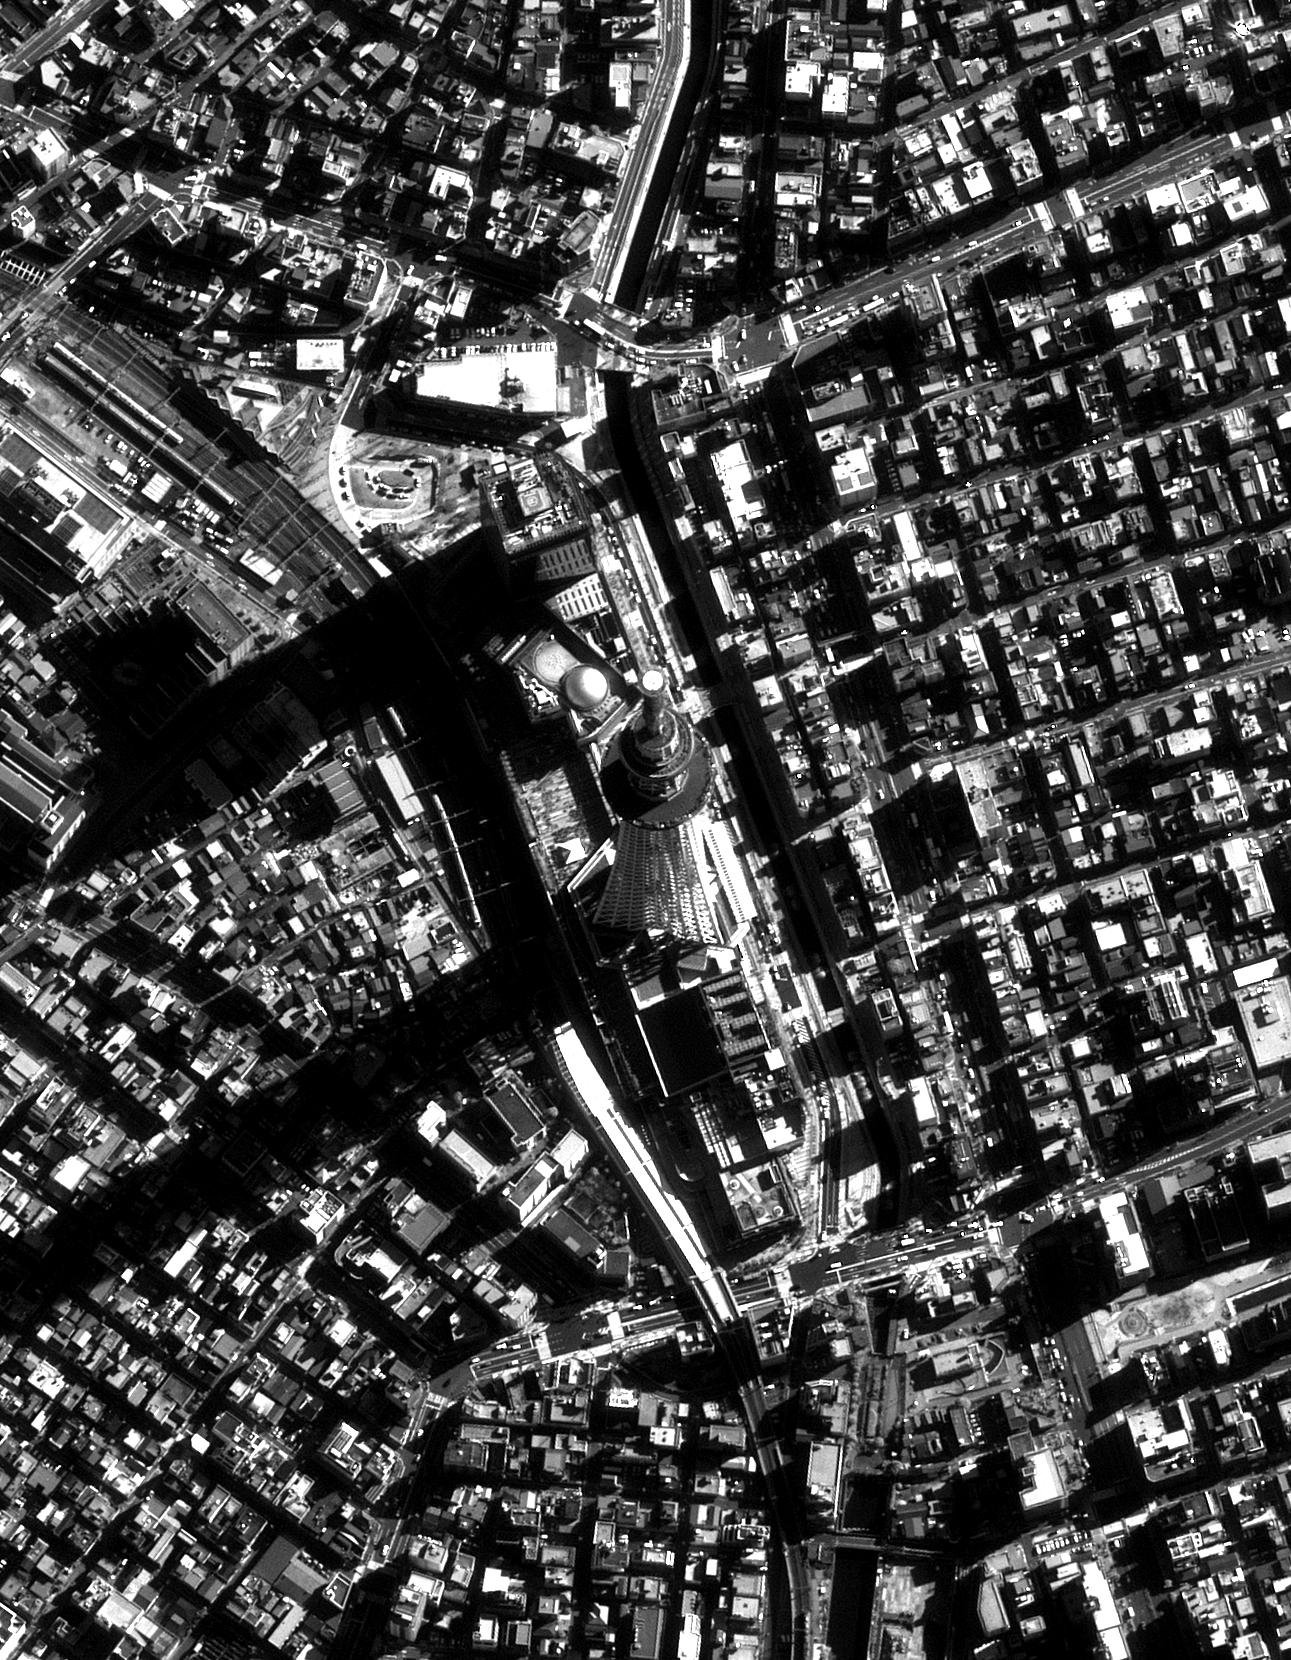
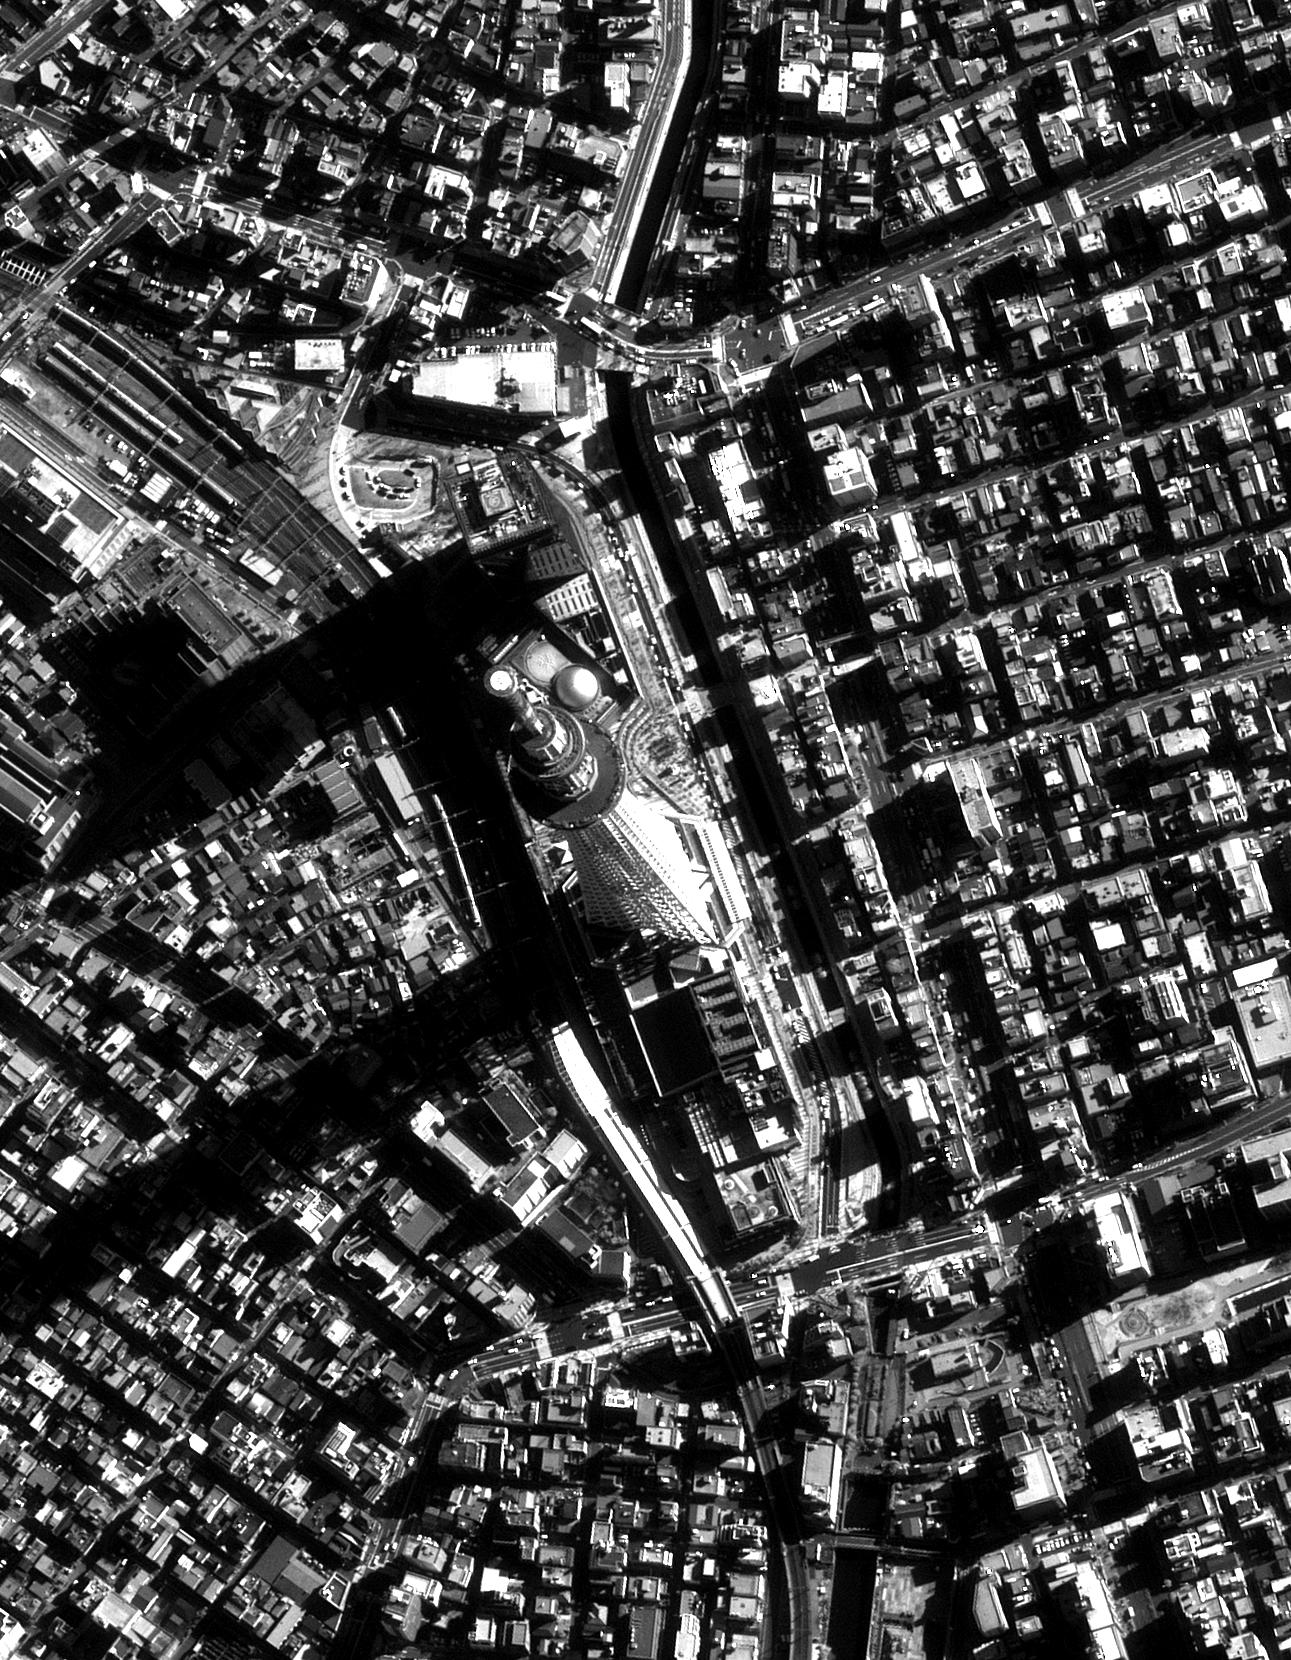

In [38]:
# show the rectified images
vistools.display_gallery([utils.simplest_color_balance_8bit(x) for x in [rect1, rect2]])

Now that we have small, rectified images, we can feed them to any standard stereo matching algorithms to find a dense set of matches.  Here, we use the implementation of Semi Global Matching seen in the stereo matching practical session, with standard filtering options.

In [39]:
# compute a disparity map between two rectified images (should take less than 1 minute)
LRS, _, _ = stereo.compute_disparity_map(rect1, rect2, dmin-50, dmax+10)

t=12.0710 done building CV
t=34.9811 done sgmfilter
t=36.7267 done aggregation and WTA refinement
t=10.8392 done building CV
t=22.3536 done sgmfilter
t=23.6881 done aggregation and WTA refinement


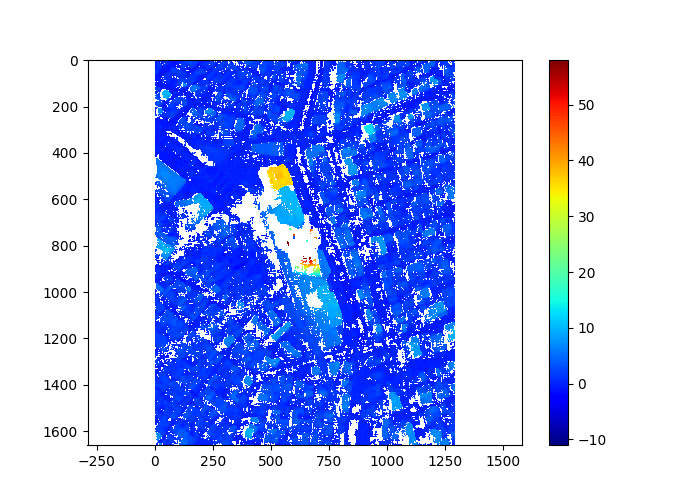

In [40]:
# display the resulting disparity map
# vistools.display_imshow(-LRS, cmap='jet', inline=True)

**Exercise 3.** Compute a few disparity maps between a central image and other images in the sequence.  How does a high baseline affect the quality of the result? (in terms of precision of the matches and density of valid points).

**Answer.**  
We selected the 11th image as the central reference and computed disparity maps for offsets ranging from 1 to 3. Initially, the number of valid points was 1M8. As the temporal distance between images increased, the number of valid points decreased (from 1M8 to 1M5). The quality of the matching degrades visually, as indicated by less consistent disparity indices. For instance, the top of the skytree tower doesn't have any matches anymore.

**Exercise 4.** ~~Write a function that transforms a disparty map into 3D point cloud.~~  For that, you have to invert the rectifying transformations to go back to the coordinates of the original (uncropped) image domain, and then triangulate these correspondences.  If your tringulation function admits vectorial inputs, then this step can be be blazingly fast!
(NOTE: it was sunny this morning, so we decided to give you an efficient answer to this exercise)

In [41]:
# code for exercise 4
def triangulate_disparities(dmap, S1, S2, PA, PB):
    """
    Triangulate a disparity map.

    Arguments:
        dmap : a disparity map between two rectified images
        S1, S2 : rectifying affine maps (from the domain of the original, full-size images)
        PA, PB : the affine approximations of the projection functions of each image

    Return:
        xyz : a matrix of size Nx3 (where N is the number of finite disparites in dmap)
              this matrix contains the coordinates of the 3d points in "lon,lat,h" or "e,n,h"
    """

    # WRITE YOUR CODE HERE
    # suggested organization:
    # 1. unroll all the valid (finite) disparities of dmap into a vector
    # 2. for each disparity
    # 2.1. produce a pair of points in the original image domain by composing with S1 and S2
    # 2.2. triangulate the pair of image points to find a 3D point (in UTM coordinates)
    # 2.3. add this point to the output list

    # 1. unroll all the valid (finite) disparities of dmap into a vector
    m = np.isfinite(dmap.flatten())
    x = np.argwhere(np.isfinite(dmap))[:,1]    # attention to order of the indices
    y = np.argwhere(np.isfinite(dmap))[:,0]
    d = dmap.flatten()[m]

    # 2. for each disparity
    # 2.1. produce a pair of points in the original image domain by composing with S1 and S2
    p = np.linalg.inv(S1) @ np.vstack( (x+0, y, np.ones(len(d))) )
    q = np.linalg.inv(S2) @ np.vstack( (x+d, y, np.ones(len(d))) )
    # 2.2. triangulate the pair of image points to find a 3D point (in UTM coordinates)

    lon, lat, h, e = triangulation_affine(PA, PB, p[0,:], p[1,:], q[0,:], q[1,:])
    east, north, zone = utils.lonlat_to_utm(lon, lat)
    # 2.3. add this point to the output list
    xyz = np.vstack((east, north, h)).T

    # map of triangulation errors
    err = dmap.copy()
    err.flat[m] = e



    return xyz, err

In [42]:
# triangulate the disparities of the previously computed case
xyz, err = triangulate_disparities(LRS, S1, S2, PA, PB)
xyz.shape  # this should be a matrix of size (npoints , 3)

(1808886, 3)

In [43]:
# compute the UTM bounding box of the obtained 3D points
min_e, min_n = np.min(xyz,axis=0)[0:2]
max_e, max_n = np.max(xyz,axis=0)[0:2]


(391967.27453780634, 392948.7855267539, 981.5109889475862)
(3952021.396796302, 3952846.7398136063, 825.3430173043162)


Now, if all went well, you should be able to display a 3D point cloud using the `display_cloud` function below

In [47]:
# save the point clouds
np.savez("xyz.npz", xyz=xyz)

In [44]:
# compute a point cloud in POTREE format (stored on disk)
import pypotree
cloud = pypotree.generate_cloud_for_display(xyz)

/usr/local/lib/python3.11/dist-packages/bin/PotreeConverter .tmp.txt -f xyz -o point_clouds -p c1c86d --material ELEVATION --edl-enabled --overwrite


In [46]:
# display the POTREE inside the notebook
# pypotree.display_cloud_colab(cloud)

**Observation.** With the default parameters, you do not recover the whole height of the skytree tower.  The disparities are just too large.  You can try to enlarge the disparity ranges given to SMG to find the top of the tower.

# Creation of a D.E.M.

Point clouds in 3D are beautiful, but in a geographical context it is often useful and easier to work with 2.5D models, called digital elevation models (DEM).  We can build a DEM by projecting a point cloud into a fixed square grid in UTM coordinates and accumulate into each square all the 3D points that fall into it.


**Exercise 5.**  ~~Write a function that projects a 3D point cloud into a DEM.  This function receives as input the desired resolution of the DEM.~~ (it was sunny this morning, so we decided to give you an efficient answer to this exercise)

In [ ]:
# first, define a helper function that will aid to project the points efficiently

from numba import jit

# this function accumulates all the 3D points into a 2.5D grid
# it computes the maximum height (or the average height, by a small change)
@jit
def reducemax( w,h,  ix, iy, z ):
    D_sum = -np.ones((h,w))*np.inf
    D_cnt = np.zeros((h,w))
    for t in range(len(ix)):
        ty = iy[t]
        tx = ix[t]
        if tx >=0 and ty >= 0 and tx < w and ty < h:
            D_sum[ty,tx] = max(D_sum[ty,tx], z[t])
            D_cnt[ty,tx] += 1
#    D_sum /= D_cnt  # needed for computing average

    return D_sum

def project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=1):
    """
    Project a point cloud into an utm grid to produce a DEM
    The algorithm is the simplest possible: just average all the points that fall into each square of the grid.

    Arguments:
        xyz : a Nx3 matrix representing a point cloud in (easting,northing,h) coordinates
        emin,emax,nmin,nmax : a bounding box in UTM coordinates
        resolution : the target resolution in meters (by default, 1 meter)

    Return:
        dem : a 2D array of heights in meters
    """

    # width and height of the image domain
    w = int(np.ceil((emax - emin)/resolution))
    h = int(np.ceil((nmax - nmin)/resolution))

    # extract and quantize columns
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]

    ix = np.asarray((x - emin)/resolution, dtype="int")
    iy = np.asarray((nmax - y)/resolution, dtype="int")

    dem = reducemax (w,h,  ix, iy, z )

    return dem

def dem_from_xyz(xyz, resolution=1):
    min_e, min_n = np.min(xyz,axis=0)[0:2] - resolution
    max_e, max_n = np.max(xyz,axis=0)[0:2] + resolution
    return project_cloud_into_utm_grid(xyz, min_e, max_e, min_n, max_n, resolution)

In [ ]:
# compute the DEM from the 3D point cloud obtained above
dem = dem_from_xyz(xyz, resolution=1)

In [ ]:
# visualize the DEM using a color palette
# see other palettes here: https://matplotlib.org/examples/color/colormaps_reference.html
vistools.display_imshow(dem, [25,100], cmap="terrain", inline=True)

If you have reached this point, you have produced a high-resolution D.E.M. from a pair of satellite images.  This is no small feat!  You have repeated in a single day a program that took us many years!

# Multi-view stereo (by DEM fusion)

Now let us see how can we merge the D.E.M. computed from several pairs of images.

In [ ]:
# function that computes a D.E.M. from a pair of images
def dem_from_pair(img_a, img_b, aoi, resolution=1):

    # run the whole pipeline
    R1, R2, S1, S2, dmin, dmax, PA, PB = rectification.rectify_aoi(img_a, img_b, aoi)
    print(f"dmin,dmax = {dmin},{dmax}")
    LRS, _, _ = stereo.compute_disparity_map(R1, R2, dmin-10, dmax+10, cost="census")
    print(f"done computing disparity map")
    xyz, _ = triangulate_disparities(LRS, S1, S2, PA, PB)
    emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
    dem = project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution)

    return dem

In [ ]:
# compute DEM from images 11 and 12
dem1 = dem_from_pair(myimages[11], myimages[12], aoi_meji)

In [ ]:
# compute DEM from images 12 and 13
dem2 = dem_from_pair(myimages[12], myimages[13], aoi_meji)

In [ ]:
# compute DEM from images 13 and 14
dem3 = dem_from_pair(myimages[13], myimages[14], aoi_meji)

In [ ]:
# visualize the computed DEMs
vistools.display_imshow(dem1, cmap="terrain", range=[20,150])


In [ ]:
# compute the average of the three
dem123 = (dem1 + dem2 + dem3)/3

In [ ]:
# view the three DEM and their average
vistools.display_gallery([2*dem1, 2*dem2, 2*dem3, 2*dem123])

Notice that the average of the three DEM is only computed at the points where all the three DEMs are defined.  Thus, by merging more and more images we will obtain less and less dense DEM.

**Exercise 6 .** Write a function that merges several DEMs into a single one, by computing the average (or the median) of the all the _avaliable_ heights at each point.  Verify that by merging more and more images you obtain denser and denser DEMs.


__answer__: we couldn't push because of RAM issue.  The more image we added, the more dense is the image

In [ ]:

def dem_fusion(dems):
    """
    Merge a list of several DEMs into a single one

    Arguments:
        dems: a list of 2D arrays of the same size

    Return:
        dem : a 2D array
    """
    # dems[dems == -np.inf] = np.nan  # Replace -inf with NaN
    for dem in dems:
      dem[dem==-np.inf]=np.nan
    return np.nanmean(dems, axis=0)

In [48]:
# result=[dem1,dem2,dem3]
# start=11

# for i in range(1,3):
#   result1=dem_fusion(result[:i])

#   vistools.display_imshow(result1, cmap="terrain", range=[20,150],title=f" Output DEM with {i} input img")

**Exercise 7. (BONUS)**  Write a function that "elevates" a DEM into a 3D point cloud, and visualize the result of your dem_fusion as a 3D point cloud.

In [ ]:
import math
def dem_elevate_to_3d(dem, emin, emax, nmin, nmax):
    """
    Elevate a DEM in UTM coordinates into a 3D point cloud

    Arguments:
        dem: a 2D array representing a DEM
        emin,emax,nmin,mnax: the corresponding UTM bounding box

    Return:
        xyz : a 2D array of size Nx3, representing a 3D point cloud
    """
    xyz = []
    # WRITE THE CODE OF QUESTION 3 HERE
    w,h = dem.shape
    for i in range(w):
        for j in range(h):
            if math.isfinite(dem[i,j]):
                x = i + emin
                y = nmax - j
                xyz.append([x, y, dem[i,j]])
    return xyz

In [ ]:
# OPTIONAL: test the "elevation" code
emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi_meji)
cloud = dem_elevate_to_3d(dem123, emin, emax, nmin, nmax)

In [ ]:
# visualize the computed cloud using the POTREE viewer
pypotree.display_cloud_colab(pypotree.generate_cloud_for_display(cloud))

# Interpolation of Digital Elevation Maps

All the DEM that we are creating have a lot of holes (missing data).  As we have seen in the course, we can interpolate them easily using linear second-order PDE.

In [ ]:
import demtk  # small toolkit for DEM interpolation

In [ ]:
# interpolate by Laplace equation using Dirichlet boundary conditions
dem1_laplace = demtk.fill_nans_by_laplace_equation(dem1)

In [ ]:
# interpolate by Laplace equation with Neumann condition on high jumps
dem1_neumann = demtk.descending_neumann_interpolation(dem1)

In [ ]:
vistools.display_gallery([2*dem1, 2*dem1_laplace, 2*dem1_neumann])

**Exercise 8. (OPTIONAL, DIFFICULT)** Build a 3D model of the Skytree tower without holes, complete up to the antenna spike.

This exercise is not for the faint of heart.  While it is conceptually simple, it requires a considerable time investiment and a comprehensive understanding of all the steps of the pipeline.  Most notably, you have to

1. Select a few appropriate pairs of images
2. For each pair, compute the disparity maps with a suitable disparity range so that the antenna spike is visible
3. Merge the resulting DEM so that only small holes remain
4. Interpolate the remaining holes
5. Elevate the complete DEM into a 3D point cloud